In [53]:
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
import numpy as np

df_web_data = pd.read_csv('../02_DATA_LIMPIO/df_web_data_combinado_limpio.csv')
df_expanded = pd.read_csv('../02_DATA_LIMPIO/df_final_expanded_limpio.csv')

In [ ]:
df_expanded

In [ ]:
df_web_data

In [2]:
# Cargar los archivos
df_web_data = pd.read_csv('../02_DATA_LIMPIO/df_web_data_combinado_limpio.csv')
df_expanded = pd.read_csv('../02_DATA_LIMPIO/df_final_expanded_limpio.csv')

# Mostrar columnas de cada archivo
print("Columnas en df_web_data:")
print(df_web_data.columns)

print("\nColumnas en df_expanded:")
print(df_expanded.columns)

Columnas en df_web_data:
Index(['client_id', 'visitor_id', 'visit_id', 'process_step', 'date_time'], dtype='object')

Columnas en df_expanded:
Index(['client_id', 'clnt_tenure_yr', 'clnt_tenure_mnth', 'clnt_age', 'gendr',
       'num_accts', 'bal', 'calls_6_mnth', 'logons_6_mnth', 'Variation',
       'total_tenure_months'],
      dtype='object')


In [3]:
# Hacemos un merge de los datos usando 'client_id' como clave común
df_merged = pd.merge(df_web_data, df_expanded, on='client_id', how='inner')

In [4]:
# Filtro los grupos según la columna 'Variation'
grupo_control = df_merged[df_merged['Variation'] == 'control']
grupo_prueba = df_merged[df_merged['Variation'] == 'test']

In [5]:
# Calculo finalizaciones (process_step == 'confirm') y visitas únicas
finalizados_control = grupo_control[grupo_control['process_step'] == 'confirm'].shape[0]
finalizados_prueba = grupo_prueba[grupo_prueba['process_step'] == 'confirm'].shape[0]
n_control = grupo_control['visit_id'].nunique()
n_prueba = grupo_prueba['visit_id'].nunique()

In [6]:
print(f"Finalizaciones - Control: {finalizados_control}, Prueba: {finalizados_prueba}")
print(f"Visitas únicas - Control: {n_control}, Prueba: {n_prueba}")

Finalizaciones - Control: 17498, Prueba: 25716
Visitas únicas - Control: 32181, Prueba: 37122


**Prueba estadística y evaluar el umbral**

In [7]:
from statsmodels.stats.proportion import proportions_ztest
import numpy as np

In [8]:
# Prueba de proporciones Z-test
counts = np.array([finalizados_prueba, finalizados_control])  # Finalizaciones
nobs = np.array([n_prueba, n_control])  # Total de visitas únicas

In [9]:
z_stat, p_value = proportions_ztest(count=counts, nobs=nobs, alternative='two-sided')

In [10]:
# Calculo las tasas
tasa_control = finalizados_control / n_control
tasa_prueba = finalizados_prueba / n_prueba
diferencia_tasa = (tasa_prueba - tasa_control) * 100

In [11]:
print(f"Estadístico Z: {z_stat:.2f}")
print(f"Valor p: {p_value:.4f}")
print(f"Tasa de finalización - Control: {tasa_control:.2%}")
print(f"Tasa de finalización - Prueba: {tasa_prueba:.2%}")
print(f"Diferencia de tasas: {diferencia_tasa:.2f}%")

Estadístico Z: 40.38
Valor p: 0.0000
Tasa de finalización - Control: 54.37%
Tasa de finalización - Prueba: 69.27%
Diferencia de tasas: 14.90%


In [12]:
# Evaluar el umbral del 5%
umbral = 5
if diferencia_tasa > umbral:
    print("La diferencia de tasas supera el umbral del 5%.")
else:
    print("La diferencia de tasas no supera el umbral del 5%.")

La diferencia de tasas supera el umbral del 5%.


In [13]:
# Creo un df con los resultados resumidos
resultados = pd.DataFrame({
    'Grupo': ['Control', 'Prueba'],
    'Tasa de Finalización': [tasa_control * 100, tasa_prueba * 100],
    'Finalizaciones': [finalizados_control, finalizados_prueba],
    'Total Visitas': [n_control, n_prueba]
})

In [26]:
resultados

,Grupo,Tasa de Finalización,Finalizaciones,Total Visitas
0,Control,54.373699,17498,32181
1,Prueba,69.274285,25716,37122


In [14]:
resultados.to_csv('../02_DATA_LIMPIO/resultados_finalizacion.csv', index=False)

**Comparar tasas por género**

In [15]:
import pandas as pd
from scipy.stats import chi2_contingency, ttest_ind

In [16]:
# Crea una columna binaria 'finalizo' para identificar finalizaciones
df_merged['finalizo'] = df_merged['process_step'] == 'confirm'

In [17]:
tabla_gendr = pd.crosstab(df_merged['gendr'], df_merged['finalizo'])

# Prueba chi-cuadrado
chi2, p_gendr, dof, expected = chi2_contingency(tabla_gendr)

print("Comparación por Género:")
print(tabla_gendr)
print(f"Chi-cuadrado: {chi2:.2f}, p-valor: {p_gendr:.4f}")

Comparación por Género:
finalizo  False  True 
gendr                 
F         90569  13721
M         93011  15002
U         94393  14491
X             8      0
Chi-cuadrado: 28.70, p-valor: 0.0000


In [18]:
# Dividimos la edad en grupos
df_merged['edad_grupo'] = pd.cut(df_merged['clnt_age'], bins=[0, 30, 50, 70, 100], labels=["<30", "30-50", "50-70", "70+"])

In [19]:
# Calculo tasas de finalización por grupo de edad
tasas_edad = df_merged.groupby('edad_grupo')['finalizo'].mean() * 100
print("Tasas de finalización por grupo de edad:")
print(tasas_edad)

Tasas de finalización por grupo de edad:
edad_grupo
<30      14.126309
30-50    14.010055
50-70    12.937783
70+      12.111657
Name: finalizo, dtype: float64


In [20]:
# ANOVA para comparar grupos de edad
grupos_edad = [df_merged[df_merged['edad_grupo'] == g]['finalizo'].astype(int) for g in df_merged['edad_grupo'].unique()]
from scipy.stats import f_oneway
anova_edad = f_oneway(*grupos_edad)
print(f"ANOVA para edad: F={anova_edad.statistic:.2f}, p-valor={anova_edad.pvalue:.4f}")

ANOVA para edad: F=38.34, p-valor=0.0000


In [21]:
# Crear grupos de número de cuentas
df_merged['num_accts_grupo'] = pd.cut(df_merged['num_accts'], bins=[0, 2, 5, 10, 20], labels=["1-2", "3-5", "6-10", "11+"])

# Calcular tasas
tasas_cuentas = df_merged.groupby('num_accts_grupo')['finalizo'].mean() * 100
print("Tasas de finalización por número de cuentas:")
print(tasas_cuentas)

# Prueba ANOVA
grupos_cuentas = [df_merged[df_merged['num_accts_grupo'] == g]['finalizo'].astype(int) for g in df_merged['num_accts_grupo'].unique()]
anova_cuentas = f_oneway(*grupos_cuentas)
print(f"ANOVA para número de cuentas: F={anova_cuentas.statistic:.2f}, p-valor={anova_cuentas.pvalue:.4f}")


Tasas de finalización por número de cuentas:
num_accts_grupo
1-2     12.988470
3-5     15.088661
6-10    20.975610
11+           NaN
Name: finalizo, dtype: float64


ANOVA para número de cuentas: F=109.19, p-valor=0.0000


**Conclusiones**

Edad:

- Los usuarios menores de 30 años y entre 30-50 años tienen tasas de finalización más altas.
- Los usuarios mayores de 50 años, especialmente los 70+, tienen tasas de finalización más bajas.

Número de cuentas:
- Los usuarios con 6-10 cuentas tienen una tasa de finalización significativamente más alta (20.98%) en comparación con otros grupos.
- Los usuarios con 3-5 cuentas también muestran mejores tasas que aquellos con solo 1-2 cuentas.


In [22]:
# Calculamos tasas de finalización por grupo de edad y tipo de variation
tasas_finalizacion = df_merged.groupby(['edad_grupo', 'Variation'])['finalizo'].mean() * 100

In [23]:
# Convertimos a DataFrame para facilitar exportación y visualización
tasas_finalizacion = tasas_finalizacion.reset_index()
tasas_finalizacion.rename(columns={'finalizo': 'tasa_finalizacion'}, inplace=True)

In [24]:
print("Tasas de finalización por edad y tipo de variation")
print(tasas_finalizacion)

Tasas de finalización por edad y tipo de variation
  edad_grupo Variation  tasa_finalizacion
0        <30   control          12.446635
1        <30      test          15.516023
2      30-50   control          12.676487
3      30-50      test          15.114197
4      50-70   control          12.026320
5      50-70      test          13.655755
6        70+   control          10.149573
7        70+      test          13.616254


In [25]:
# Guardamos resultados en un archivo CSV para Tableau
tasas_finalizacion.to_csv('../02_DATA_LIMPIO/tasas_finalizacion_edad_variation.csv', index=False)

In [27]:
import matplotlib.pyplot as plt

In [43]:
# Colores para las gráficas
base_color = "#740019"
complementary_color = "#026660"

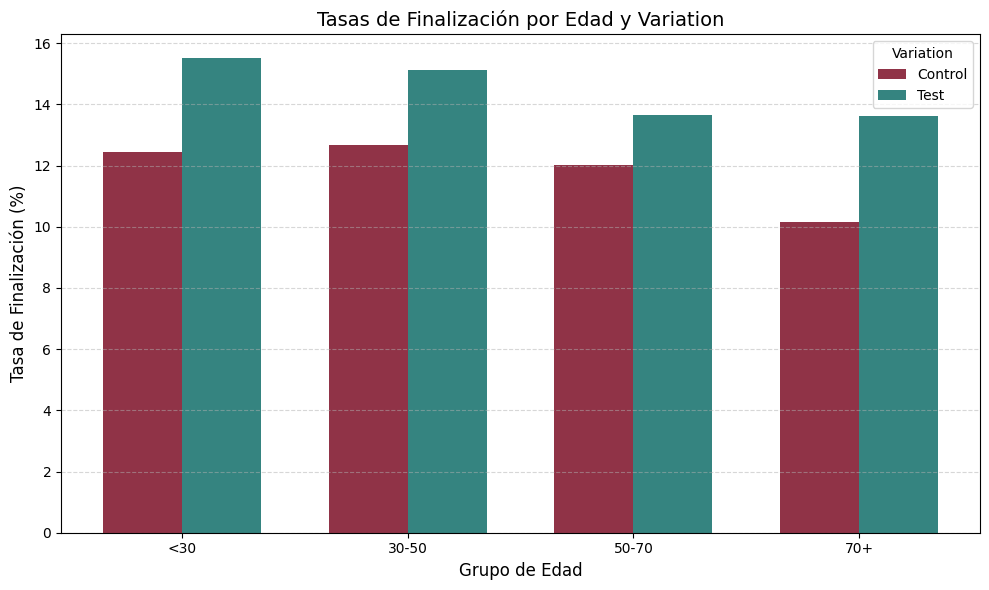

In [44]:
# Ajustamos el gráfico de barras agrupadas para mejorar la visibilidad
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35  # Ancho de las barras
x_labels = tasas_finalizacion['edad_grupo'].unique()
x = range(len(x_labels))

# Filtramos datos por tipo de variation
control_data = tasas_finalizacion[tasas_finalizacion['Variation'] == 'control']
test_data = tasas_finalizacion[tasas_finalizacion['Variation'] == 'test']

# Gráfico barras desplazadas
ax.bar(
    [pos - bar_width / 2 for pos in x],
    control_data['tasa_finalizacion'],
    width=bar_width,
    label='Control',
    color=base_color,
    alpha=0.8
)
ax.bar(
    [pos + bar_width / 2 for pos in x],
    test_data['tasa_finalizacion'],
    width=bar_width,
    label='Test',
    color=complementary_color,
    alpha=0.8
)

# Personalizamos el gráfico
ax.set_title('Tasas de Finalización por Edad y Variation', fontsize=14)
ax.set_xlabel('Grupo de Edad', fontsize=12)
ax.set_ylabel('Tasa de Finalización (%)', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.legend(title='Variation')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


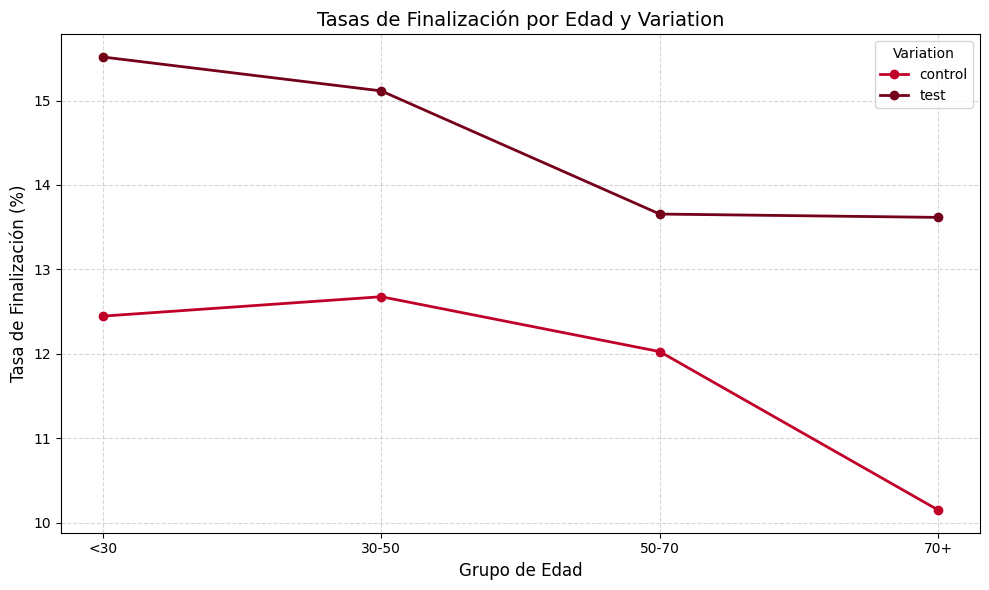

In [36]:
# Gráfico de líneas con colores personalizados
fig, ax = plt.subplots(figsize=(10, 6))
for i, variation in enumerate(tasas_finalizacion['Variation'].unique()):
    subset = tasas_finalizacion[tasas_finalizacion['Variation'] == variation]
    color = base_color if i == 0 else complementary_color
    ax.plot(subset['edad_grupo'], subset['tasa_finalizacion'], marker='o', label=variation, color=color, linewidth=2)

ax.set_title('Tasas de Finalización por Edad y Variation', fontsize=14)
ax.set_xlabel('Grupo de Edad', fontsize=12)
ax.set_ylabel('Tasa de Finalización (%)', fontsize=12)
ax.legend(title='Variation')
plt.grid(axis='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



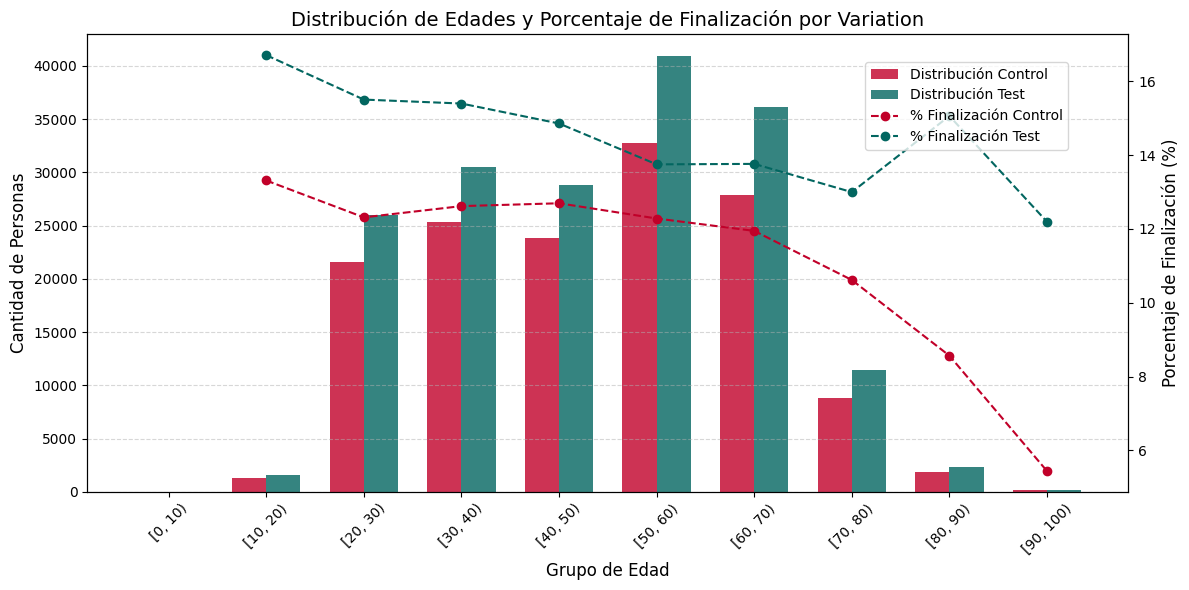

In [42]:
# Calculamos el porcentaje de personas que completan el proceso por edad y tipo de Variation
df_merged['edad_grupo'] = pd.cut(df_merged['clnt_age'], bins=range(0, 101, 10), right=False)

# Calculamos distribución y finalización para control y test
distribucion_variation = df_merged.groupby(['edad_grupo', 'Variation']).size().unstack()
finalizacion_variation = df_merged.groupby(['edad_grupo', 'Variation'])['finalizo'].mean().unstack() * 100

# Creamos un gráfico combinado
fig, ax1 = plt.subplots(figsize=(12, 6))

# Gráfico de barras para la distribución de edades
bar_width = 0.35  # Ancho de las barras
x = range(len(distribucion_variation.index))  # Posiciones de los grupos de edad

ax1.bar(
    [pos - bar_width / 2 for pos in x],
    distribucion_variation['control'],
    width=bar_width,
    color=base_color,
    alpha=0.8,
    label='Distribución Control'
)
ax1.bar(
    [pos + bar_width / 2 for pos in x],
    distribucion_variation['test'],
    width=bar_width,
    color=complementary_color,
    alpha=0.8,
    label='Distribución Test'
)

ax1.set_xlabel('Grupo de Edad', fontsize=12)
ax1.set_ylabel('Cantidad de Personas', fontsize=12, color='black')
ax1.set_xticks(x)
ax1.set_xticklabels(distribucion_variation.index.astype(str), rotation=45)
ax1.set_title('Distribución de Edades y Porcentaje de Finalización por Variation', fontsize=14)
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# Gráfico de línea para el porcentaje de finalización
ax2 = ax1.twinx()
ax2.plot(
    x, finalizacion_variation['control'],
    color=base_color, marker='o', label='% Finalización Control', linestyle='--'
)
ax2.plot(
    x, finalizacion_variation['test'],
    color=complementary_color, marker='o', label='% Finalización Test', linestyle='--'
)
ax2.set_ylabel('Porcentaje de Finalización (%)', fontsize=12, color='black')

# Leyendas y ajustes
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.9))
plt.tight_layout()
plt.show()


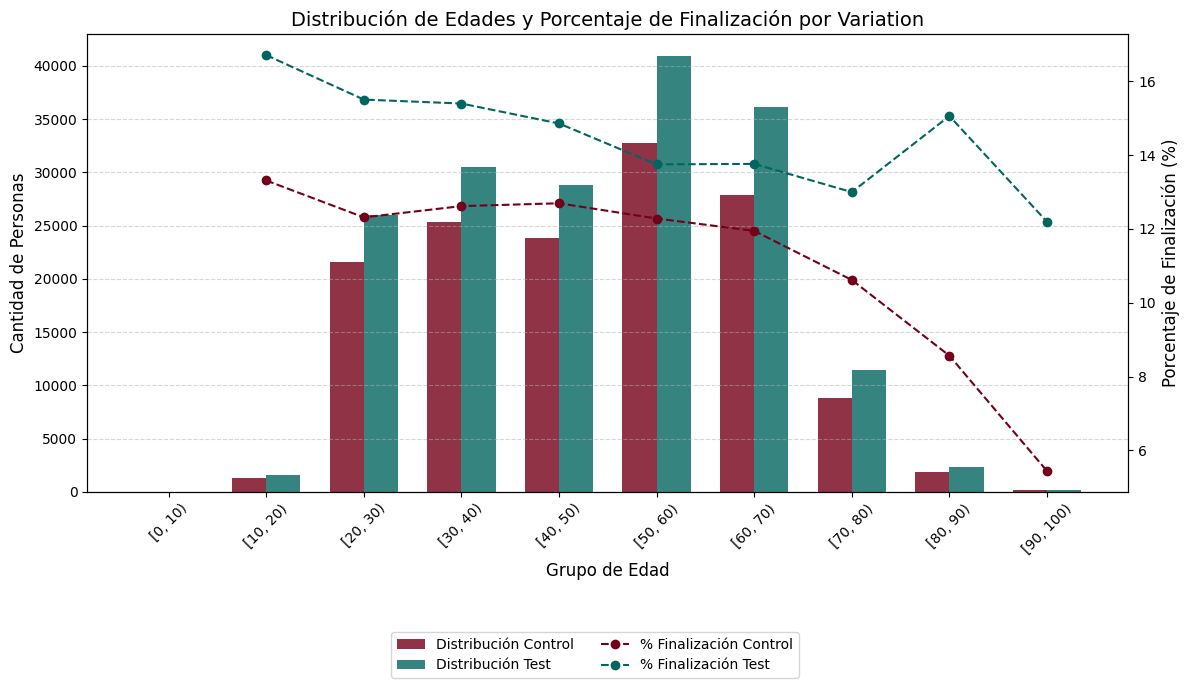

In [45]:
# Crear un gráfico combinado sin la leyenda superpuesta
fig, ax1 = plt.subplots(figsize=(12, 6))

# Gráfico de barras para la distribución de edades
bar_width = 0.35  # Ancho de las barras
x = range(len(distribucion_variation.index))  # Posiciones de los grupos de edad

ax1.bar(
    [pos - bar_width / 2 for pos in x],
    distribucion_variation['control'],
    width=bar_width,
    color=base_color,
    alpha=0.8,
    label='Distribución Control'
)
ax1.bar(
    [pos + bar_width / 2 for pos in x],
    distribucion_variation['test'],
    width=bar_width,
    color=complementary_color,
    alpha=0.8,
    label='Distribución Test'
)

ax1.set_xlabel('Grupo de Edad', fontsize=12)
ax1.set_ylabel('Cantidad de Personas', fontsize=12, color='black')
ax1.set_xticks(x)
ax1.set_xticklabels(distribucion_variation.index.astype(str), rotation=45)
ax1.set_title('Distribución de Edades y Porcentaje de Finalización por Variation', fontsize=14)
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# Gráfico de línea para el porcentaje de finalización
ax2 = ax1.twinx()
ax2.plot(
    x, finalizacion_variation['control'],
    color=base_color, marker='o', label='% Finalización Control', linestyle='--'
)
ax2.plot(
    x, finalizacion_variation['test'],
    color=complementary_color, marker='o', label='% Finalización Test', linestyle='--'
)
ax2.set_ylabel('Porcentaje de Finalización (%)', fontsize=12, color='black')

# Colocar la leyenda fuera del gráfico
fig.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=2, fontsize=10)
plt.tight_layout()
plt.show()


<Axes: xlabel='process_step'>

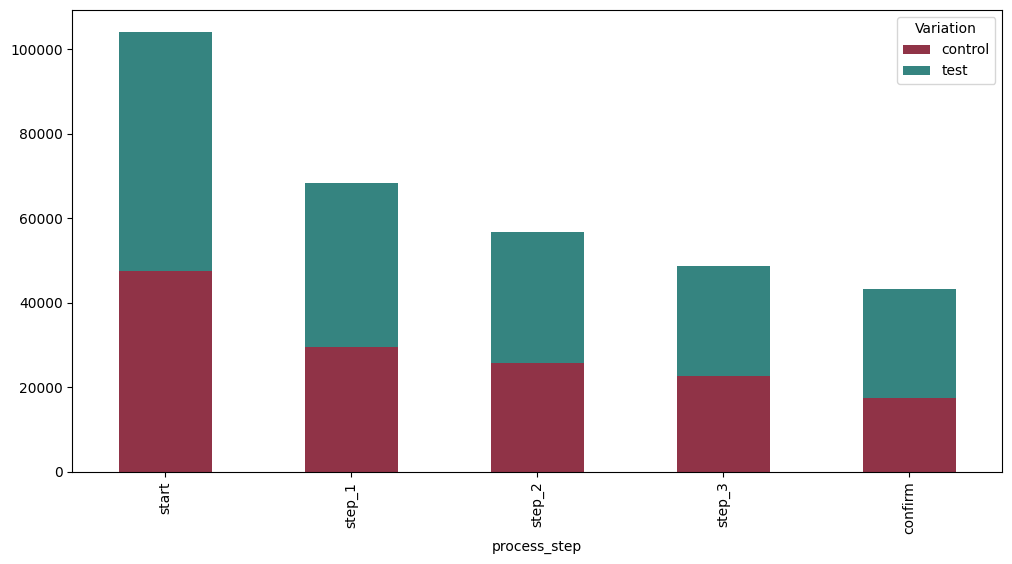

In [47]:
# Orden de los pasos
process_order = ['start', 'step_1', 'step_2', 'step_3', 'confirm']

# Filtrar y agrupar los datos
flujo_variation = (
    df_merged.groupby(['process_step', 'Variation'])
    .size()
    .unstack()
    .reindex(process_order)  # Reordenar según el flujo definido
)

# Crear un gráfico de barras apiladas para visualizar el flujo
fig, ax = plt.subplots(figsize=(12, 6))

flujo_variation.plot(
    kind='bar', stacked=True, color=[base_color, complementary_color], ax=ax, alpha=0.8
)


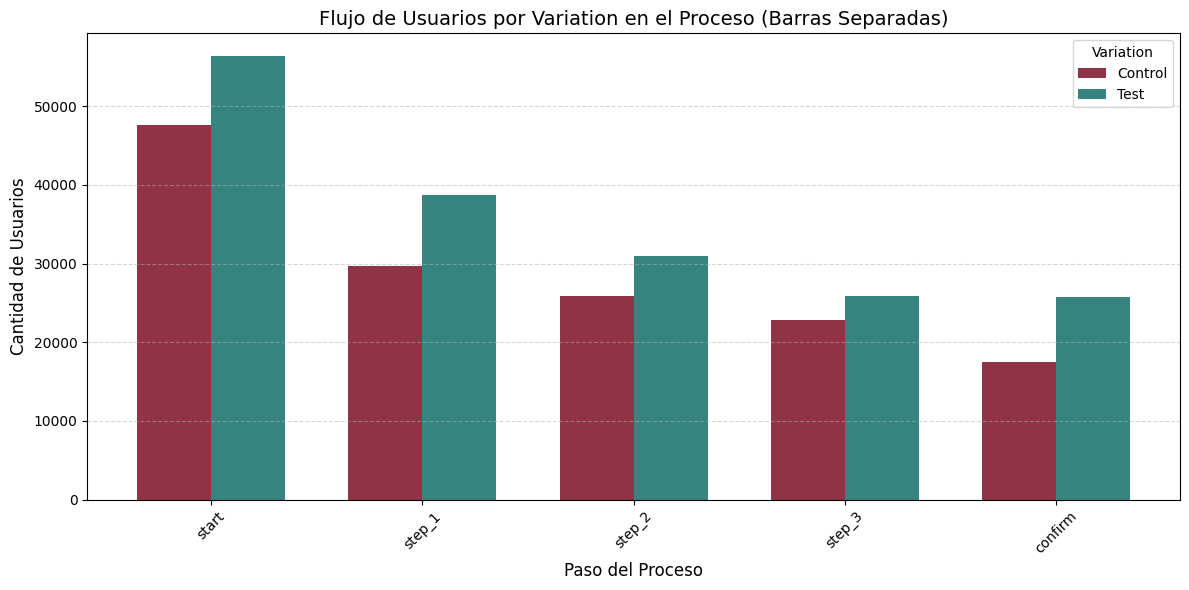

In [48]:
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
x = range(len(flujo_variation.index))  # Posiciones de los pasos del proceso

# Flujo para control
ax.bar(
    [pos - bar_width / 2 for pos in x],
    flujo_variation['control'],
    width=bar_width,
    color=base_color,
    label='Control',
    alpha=0.8
)

# Flujo para test
ax.bar(
    [pos + bar_width / 2 for pos in x],
    flujo_variation['test'],
    width=bar_width,
    color=complementary_color,
    label='Test',
    alpha=0.8
)

ax.set_title('Flujo de Usuarios por Variation en el Proceso (Barras Separadas)', fontsize=14)
ax.set_xlabel('Paso del Proceso', fontsize=12)
ax.set_ylabel('Cantidad de Usuarios', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(flujo_variation.index, rotation=45)
ax.legend(title='Variation')
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

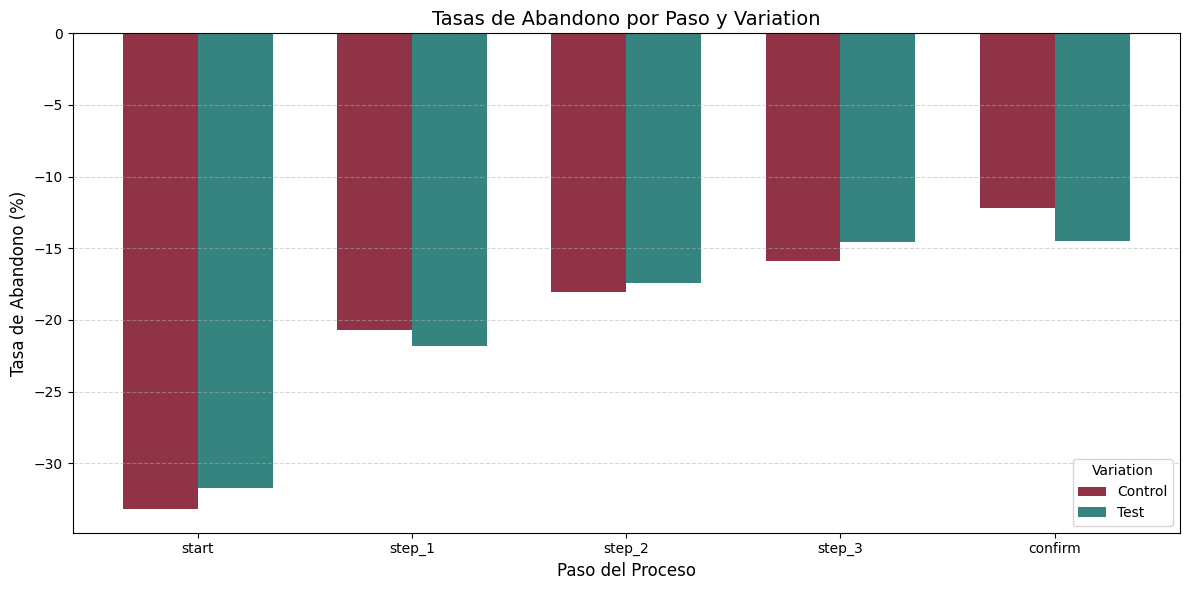

In [51]:
# Total de usuarios por tipo de Variation
total_users_variation = df_merged.groupby('Variation').size()

# Usuarios por paso del proceso y Variation
usuarios_por_paso = df_merged.groupby(['process_step', 'Variation']).size().unstack().reindex(process_order)

# Calcular tasas de abandono
drop_off_rates = usuarios_por_paso.div(total_users_variation, axis=1).cumsum().diff().fillna(usuarios_por_paso.div(total_users_variation, axis=1))

# Cambiar el signo para reflejar abandono como valor positivo
drop_off_rates = -drop_off_rates


fig, ax = plt.subplots(figsize=(12, 6))

# Tasas de abandono para control
ax.bar(
    [pos - bar_width / 2 for pos in x],
    drop_off_rates['control'] * 100,
    width=bar_width,
    color=base_color,
    label='Control',
    alpha=0.8
)

# Tasas de abandono para test
ax.bar(
    [pos + bar_width / 2 for pos in x],
    drop_off_rates['test'] * 100,
    width=bar_width,
    color=complementary_color,
    label='Test',
    alpha=0.8
)

ax.set_title('Tasas de Abandono por Paso y Variation', fontsize=14)
ax.set_xlabel('Paso del Proceso', fontsize=12)
ax.set_ylabel('Tasa de Abandono (%)', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(drop_off_rates.index)
ax.legend(title='Variation')
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [54]:
# Fusionar los datos usando 'client_id' como clave
df_merged = pd.merge(df_web_data, df_expanded, on='client_id', how='inner')

# Filtrar datos para identificar el último paso "confirm" por usuario
# Ordenar los datos por cliente y tiempo
df_merged['date_time'] = pd.to_datetime(df_merged['date_time'])
df_sorted = df_merged.sort_values(by=['client_id', 'date_time'])

# Obtener el último paso "confirm" para cada cliente
last_step = df_sorted[df_sorted['process_step'] == 'confirm'].drop_duplicates(subset=['client_id'], keep='last')

# Calcular la tasa de finalización para cada Variation
tasa_finalizacion = last_step.groupby('Variation')['process_step'].count() / df_sorted.groupby('Variation')['client_id'].nunique() * 100

# Calcular el incremento del test sobre el control
tasa_control = tasa_finalizacion['control']
tasa_test = tasa_finalizacion['test']
incremento = tasa_test - tasa_control

# Evaluar si supera el umbral del 5%
umbral = 5
cumple_umbral = incremento > umbral

# Mostrar resultados
tasa_finalizacion, incremento, cumple_umbral


(Variation
 control    65.578509
 test       69.292682
 dtype: float64,
 3.7141731383920416,
 False)

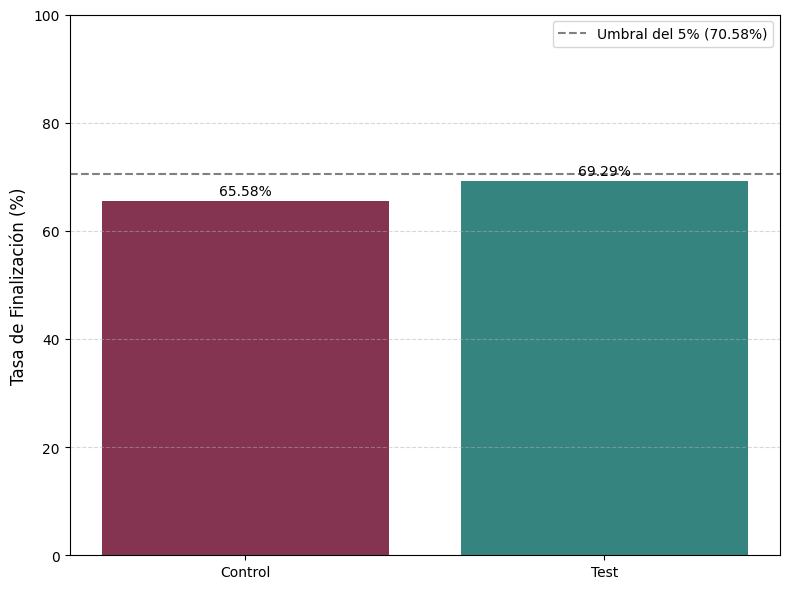

In [56]:
# Definir colores personalizados nuevamente
base_color = "#660026"
complementary_color = "#026660"

# Crear un gráfico de barras para mostrar las tasas de finalización
fig, ax = plt.subplots(figsize=(8, 6))

# Datos para el gráfico
labels = ['Control', 'Test']
values = [tasa_control, tasa_test]
colors = [base_color, complementary_color]

# Crear barras
ax.bar(labels, values, color=colors, alpha=0.8)

# Agregar detalles al gráfico
ax.set_ylabel('Tasa de Finalización (%)', fontsize=12)
ax.set_ylim(0, 100)
ax.axhline(y=tasa_control + umbral, color='gray', linestyle='--', label=f'Umbral del 5% ({tasa_control + umbral:.2f}%)')

# Mostrar valores en las barras
for i, v in enumerate(values):
    ax.text(i, v + 1, f'{v:.2f}%', ha='center', fontsize=10)

# Agregar leyenda y diseño
ax.legend(loc='upper right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
